In [66]:
import cv2 as cv
from matplotlib import pyplot as plt
import time
import numpy as np

# cv compatibility with Wayland (run opencv with QT_QPA_PLATFORM=xcb)
#import os
#os.environ["QT_QPA_PLATFORM"] = "xcb"

In [67]:
net = cv.dnn.readNetFromDarknet('../yolo_weights/yolov4-tiny.cfg', '../yolo_weights/yolov4-tiny_best.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [68]:
# determine the output layer
ln = net.getLayerNames()
print(ln)
print(net.getUnconnectedOutLayers())
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'slice_3', 'conv_4', 'bn_4', 'leaky_5', 'conv_5', 'bn_5', 'leaky_6', 'concat_6', 'conv_7', 'bn_7', 'leaky_8', 'concat_8', 'pool_9', 'conv_10', 'bn_10', 'leaky_11', 'slice_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'concat_14', 'conv_15', 'bn_15', 'leaky_16', 'concat_16', 'pool_17', 'conv_18', 'bn_18', 'leaky_19', 'slice_19', 'conv_20', 'bn_20', 'leaky_21', 'conv_21', 'bn_21', 'leaky_22', 'concat_22', 'conv_23', 'bn_23', 'leaky_24', 'concat_24', 'pool_25', 'conv_26', 'bn_26', 'leaky_27', 'conv_27', 'bn_27', 'leaky_28', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'permute_30', 'yolo_30', 'identity_31', 'conv_32', 'bn_32', 'leaky_33', 'upsample_33', 'concat_34', 'conv_35', 'bn_35', 'leaky_36', 'conv_36', 'permute_37', 'yolo_37')
[66 78]


In [69]:
img = cv.imread('test2.jpg')
blob = cv.dnn.blobFromImage(img, 1/255.0, (512, 320), swapRB=True, crop=False)

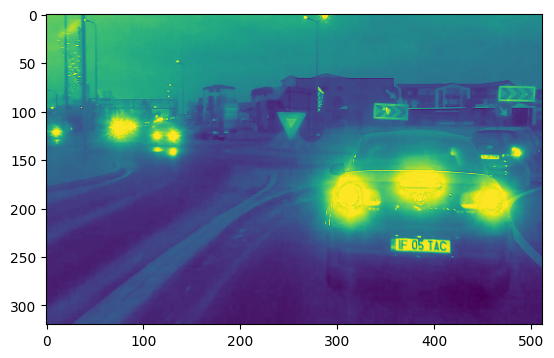

In [70]:
r = blob[0, 0, :, :]
plt.imshow(r)
#text = f'Blob shape={blob.shape}'
#cv.displayOverlay('blob', text)

In [71]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()

elapsed_ms = (t - t0)*1000
fps = 1.0/(t - t0)

print('time=', elapsed_ms)
print('fps=', fps)

time= 89.83278274536133
fps= 11.13179364413752


In [72]:
print(len(outputs))
for out in outputs:
    print(out.shape)

2
(480, 6)
(1920, 6)


In [73]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

In [74]:
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        if confidence <= 0.5:
            continue

        box = detection[:4] * np.array([w, h, w, h])
        (centerX, centerY, width, height) = box.astype("int")
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        box = [x, y, int(width), int(height)]
        boxes.append(box)
        confidences.append(float(confidence))
        classIDs.append(classID)


In [75]:
boxes

[[875, 517, 182, 41]]

In [76]:
indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

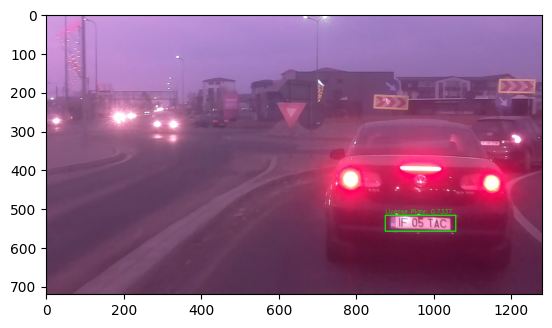

In [77]:
for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    label = "{}: {:.4f}".format('License Plate', confidences[i])
    cv.putText(img, label, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.imshow(img[:,:,::-1])
plt.show()

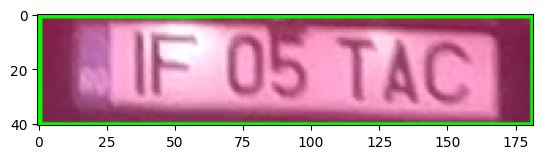

In [78]:
# only show the license plate
for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    roi = img[y:y+h, x:x+w]
    plt.imshow(roi[:,:,::-1])
    plt.show()